# Mahalanobis Distance

- Example 1. How to compute Mahalanobis Distance in Python
- Usecase 1: Multivariate outlier detection using Mahalanobis distance
- Usecase 2: Mahalanobis Distance for Classification Problems
- Usecase 3: One-Class Classification

## Example_1. How to compute Mahalanobis Distance in Python

In [1]:
import pandas as pd
import scipy  as sp
import numpy  as np

In [2]:
filepath = 'https://raw.githubusercontent.com/selva86/datasets/master/diamonds.csv'
df = pd.read_csv(filepath).iloc[:, [0,4,6]]
df.head()

,carat,depth,price
0,0.23,61.5,326
1,0.21,59.8,326
2,0.23,56.9,327
3,0.29,62.4,334
4,0.31,63.3,335


In [5]:
from scipy import linalg

def mahalanobis(x=None, data=None, cov=None):
    """Compute the Mahalanobis Distance between each row of x and the data  
    x    : vector or matrix of data with, say, p columns.
    data : ndarray of the distribution from which Mahalanobis distance of each observation of x is to be computed.
    cov  : covariance matrix (p x p) of the distribution. If None, will be computed from data.
    """
    x_minus_mu = x - np.mean(data)
    if not cov:
        cov = np.cov(data.values.T)
    inv_covmat = linalg.inv(cov)
    left_term = np.dot(x_minus_mu, inv_covmat)
    mahal = np.dot(left_term, x_minus_mu.T)
    return mahal.diagonal()

In [6]:
df_x = df[['carat', 'depth', 'price']].head(500)
df_x['mahala'] = mahalanobis(x=df_x, data=df[['carat', 'depth', 'price']])
df_x.head()

,carat,depth,price,mahala
0,0.23,61.5,326,1.709860
1,0.21,59.8,326,3.540097
2,0.23,56.9,327,12.715021
3,0.29,62.4,334,1.454469
4,0.31,63.3,335,2.347239


## Usecase 1: Multivariate outlier detection using Mahalanobis distance

In [7]:
# Critical values for two degrees of freedom
from scipy.stats import chi2
chi2.ppf((1-0.01), df=2)
#> 9.21

9.21034037197618

In [8]:
# Compute the P-Values
df_x['p_value'] = 1 - chi2.cdf(df_x['mahala'], 2)

In [9]:
# Extreme values with a significance level of 0.01
df_x.loc[df_x.p_value < 0.01].head(10)

,carat,depth,price,mahala,p_value
2,0.23,56.9,327,12.715021,0.001734
91,0.86,55.1,2757,23.909643,0.000006
97,0.96,66.3,2759,11.781773,0.002765
172,1.17,60.2,2774,9.279459,0.009660
204,0.98,67.9,2777,20.086616,0.000043
221,0.70,57.2,2782,10.405659,0.005501
227,0.84,55.1,2782,23.548379,0.000008
255,1.05,65.8,2789,11.237146,0.003630
284,1.00,58.2,2795,10.349019,0.005659
298,1.01,67.4,2797,17.716144,0.000142


# Usecase 2: Mahalanobis Distance for Classification Problems

In [10]:
df = pd.read_csv(
    'https://raw.githubusercontent.com/selva86/datasets/master/BreastCancer.csv', 
    usecols=[
        'Cl.thickness',
        'Cell.size',
        'Marg.adhesion',
        'Epith.c.size',
        'Bare.nuclei',
        'Bl.cromatin',
        'Normal.nucleoli',
        'Mitoses',
        'Class'
    ]
)

df.dropna(inplace=True)  # drop missing values.
df.head()

,Cl.thickness,Cell.size,Marg.adhesion,Epith.c.size,Bare.nuclei,Bl.cromatin,Normal.nucleoli,Mitoses,Class
0,5,1,1,2,1.0,3,1,1,0
1,5,4,5,7,10.0,3,2,1,0
2,3,1,1,2,2.0,3,1,1,0
3,6,8,1,3,4.0,3,7,1,0
4,4,1,3,2,1.0,3,1,1,0


In [12]:
from sklearn.model_selection import train_test_split
xtrain, xtest, ytrain, ytest = train_test_split(df.drop('Class', axis=1), df['Class'], test_size=.3, random_state=100)

In [13]:
# Split the training data as pos and neg
xtrain_pos = xtrain.loc[ytrain == 1, :]
xtrain_neg = xtrain.loc[ytrain == 0, :]

In [14]:
class MahalanobisBinaryClassifier():
    def __init__(self, xtrain, ytrain):
        self.xtrain_pos = xtrain.loc[ytrain == 1, :]
        self.xtrain_neg = xtrain.loc[ytrain == 0, :]

    def predict_proba(self, xtest):
        pos_neg_dists = [(p,n) for p, n in zip(mahalanobis(xtest, self.xtrain_pos), mahalanobis(xtest, self.xtrain_neg))]
        return np.array([(1-n/(p+n), 1-p/(p+n)) for p,n in pos_neg_dists])

    def predict(self, xtest):
        return np.array([np.argmax(row) for row in self.predict_proba(xtest)])

In [15]:
clf = MahalanobisBinaryClassifier(xtrain, ytrain)        
pred_probs = clf.predict_proba(xtest)
pred_class = clf.predict(xtest)

In [16]:
# Pred and Truth
pred_actuals = pd.DataFrame([(pred, act) for pred, act in zip(pred_class, ytest)], columns=['pred', 'true'])
print(pred_actuals[:5])     

   pred  true
0     0     0
1     1     1
2     0     0
3     0     0
4     0     0


In [17]:
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, confusion_matrix
truth = pred_actuals.loc[:, 'true']
pred = pred_actuals.loc[:, 'pred']
scores = np.array(pred_probs)[:, 1]
print('AUROC: ', roc_auc_score(truth, scores))
print('\nConfusion Matrix: \n', confusion_matrix(truth, pred))
print('\nAccuracy Score: ', accuracy_score(truth, pred))
print('\nClassification Report: \n', classification_report(truth, pred))

AUROC:  0.990974358974359

Confusion Matrix: 
 [[113  17]
 [  0  75]]

Accuracy Score:  0.9170731707317074

Classification Report: 
               precision    recall  f1-score   support

           0       1.00      0.87      0.93       130
           1       0.82      1.00      0.90        75

    accuracy                           0.92       205
   macro avg       0.91      0.93      0.91       205
weighted avg       0.93      0.92      0.92       205



## Usecase 3: One-Class Classification

Let’s try this on the `BreastCancer` dataset, only this time we will consider only the malignant observations (class column=1) in the training data.

In [18]:
df = pd.read_csv(
    'https://raw.githubusercontent.com/selva86/datasets/master/BreastCancer.csv',
    usecols=[
        'Cl.thickness',
        'Cell.size',
        'Marg.adhesion',
        'Epith.c.size',
        'Bare.nuclei',
        'Bl.cromatin',
        'Normal.nucleoli',
        'Mitoses',
        'Class'
    ]
)

df.dropna(inplace=True)  # drop missing values.

In [19]:
from sklearn.model_selection import train_test_split
xtrain, xtest, ytrain, ytest = train_test_split(df.drop('Class', axis=1), df['Class'], test_size=.5, random_state=100)

In [20]:
# Split the training data as pos and neg
xtrain_pos = xtrain.loc[ytrain == 1, :]

In [22]:
class MahalanobisOneclassClassifier():
    def __init__(self, xtrain, significance_level=0.01):
        self.xtrain = xtrain
        self.critical_value = chi2.ppf((1-significance_level), df=xtrain.shape[1]-1)
        print('Critical value is: ', self.critical_value)

    def predict_proba(self, xtest):
        mahalanobis_dist = mahalanobis(xtest, self.xtrain)
        self.pvalues = 1 - chi2.cdf(mahalanobis_dist, 2)
        return mahalanobis_dist

    def predict(self, xtest):
        return np.array([int(i) for i in self.predict_proba(xtest) > self.critical_value])

In [24]:
clf = MahalanobisOneclassClassifier(xtrain_pos, significance_level=0.05)
mahalanobis_dist = clf.predict_proba(xtest)

Critical value is:  14.067140449340169


In [25]:
# Pred and Truth
mdist_actuals = pd.DataFrame([(m, act) for m, act in zip(mahalanobis_dist, ytest)], columns=['mahal', 'true_class'])
print(mdist_actuals[:5])            

       mahal  true_class
0  13.104716           0
1  14.408570           1
2  14.932236           0
3  14.588622           0
4  15.471064           0


In [26]:
# quantile cut in 10 pieces
mdist_actuals['quantile'] = pd.qcut(mdist_actuals['mahal'],
                                    q=[0, .10, .20, .3, .4, .5, .6, .7, .8, .9, 1],
                                    labels=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
                                   )

In [27]:
# sort by mahalanobis distance
mdist_actuals.sort_values('mahal', inplace=True)
perc_truths = mdist_actuals.groupby('quantile').agg({'mahal': np.mean, 'true_class': np.sum}).rename(columns={'mahal':'avg_mahaldist', 'true_class':'sum_of_trueclass'})
print(perc_truths)

          avg_mahaldist  sum_of_trueclass
quantile                                 
1              3.765496                33
2              6.511026                32
3              9.272944                30
4             12.209504                20
5             14.455050                 4
6             15.684493                 4
7             17.368633                 3
8             18.840714                 1
9             21.533159                 2
10            23.524055                 1


In [28]:
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, confusion_matrix

# Positive if mahalanobis 
pred_actuals = pd.DataFrame([(int(p), y) for y, p in zip(ytest, clf.predict_proba(xtest) < clf.critical_value)], columns=['pred', 'true'])

# Accuracy Metrics
truth = pred_actuals.loc[:, 'true']
pred = pred_actuals.loc[:, 'pred']
print('\nConfusion Matrix: \n', confusion_matrix(truth, pred))
print('\nAccuracy Score: ', accuracy_score(truth, pred))
print('\nClassification Report: \n', classification_report(truth, pred))


Confusion Matrix: 
 [[183  29]
 [ 15 115]]

Accuracy Score:  0.8713450292397661

Classification Report: 
               precision    recall  f1-score   support

           0       0.92      0.86      0.89       212
           1       0.80      0.88      0.84       130

    accuracy                           0.87       342
   macro avg       0.86      0.87      0.87       342
weighted avg       0.88      0.87      0.87       342



## Label Encoding

In [29]:
import numpy  as np
import pandas as pd

In [30]:
df_trn = pd.read_csv('../data/training_le.csv')
df_tst = pd.read_csv('../data/test_le.csv')
df_sbm = pd.read_csv('../data/sample_submission.csv')

In [31]:
X_trn = df_trn.drop(columns=['TransactionStartTime', 'FraudResult'], axis=1)
X_tst = df_tst.drop(columns=['TransactionStartTime'               ], axis=1)

y_trn = df_trn['FraudResult']

In [32]:
X_trn.head()

,BatchId,AccountId,SubscriptionId,CustomerId,ProviderId,ProductId,ProductCategory,ChannelId,Amount,Value,PricingStrategy
0,36122,3956,886,4405,5,9,0,2,1000.0,1000,2
1,15641,4840,3828,4405,3,5,2,1,-20.0,20,2
2,53940,4228,221,4682,5,0,0,2,500.0,500,2
3,102362,647,2184,987,0,20,9,2,20000.0,21800,2
4,38779,4840,3828,987,3,5,2,1,-644.0,644,2


In [59]:
from scipy import linalg

def mahalanobis(x=None, data=None, cov=None):
    """Compute the Mahalanobis Distance between each row of x and the data  
    x    : vector or matrix of data with, say, p columns.
    data : ndarray of the distribution from which Mahalanobis distance of each observation of x is to be computed.
    cov  : covariance matrix (p x p) of the distribution. If None, will be computed from data.
    """
    x_minus_mu = x - np.mean(data)
    if not cov:
        cov = np.cov(data.values.T)
    inv_covmat   = linalg.inv(cov)
    left_term    = np.dot(x_minus_mu, inv_covmat)
    x_minus_mu_T = x_minus_mu.T
    mahal        = np.zeros(left_term.shape[0])
    for i in range(left_term.shape[0]):
        mahal[i] = np.dot(left_term[i], x_minus_mu_T[i])
    return mahal

In [60]:
X_trn_2 = X_trn[['Amount', 'Value']]
X_tst_2 = X_tst[['Amount', 'Value']]

X_trn_2['Mahalanobis'] = mahalanobis(x=X_trn_2, data=X_trn_2)
X_trn_2.head()

/home/abogatyrov/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


,Amount,Value,Mahalanobis
0,1000.0,1000,0.036127
1,-20.0,20,0.036380
2,500.0,500,0.036643
3,20000.0,21800,0.016438
4,-644.0,644,0.016194


In [62]:
# Critical values for two degrees of freedom
from scipy.stats import chi2
chi2.ppf((1-0.01), df=2)

9.21034037197618

In [150]:
# Compute the P-Values
X_trn_2['p_value'] = 1 - chi2.cdf(X_trn_2['Mahalanobis'], 3)

/home/abogatyrov/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [151]:
# Extreme values with a significance level of 0.01
predict_trn = np.where(X_trn_2.p_value < 1e-7, 1, 0)

In [152]:
predict_trn.sum()

290

In [153]:
from sklearn.metrics import f1_score
f1_score(y_trn, predict_trn)

0.37267080745341613

In [137]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_trn, predict_trn)

array([[95269,   200],
       [  101,    92]])

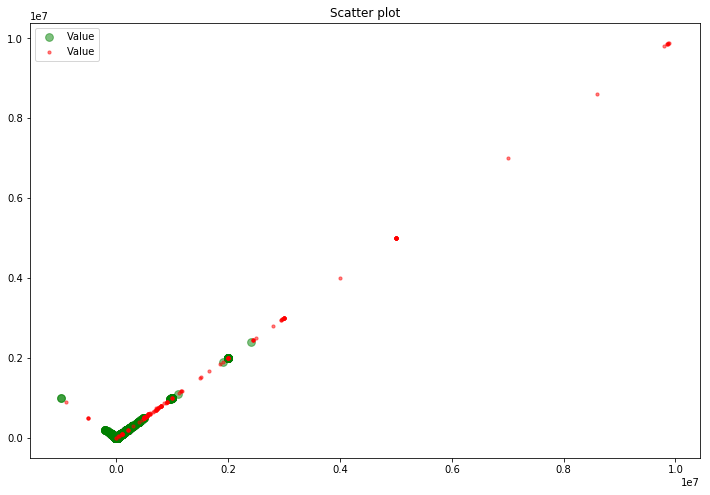

In [193]:
import numpy as np
import matplotlib.pyplot as plt

# Create data
fraud   = df_trn[['Amount', 'Value']][df_trn.FraudResult == 1]
nofraud = df_trn[['Amount', 'Value']][df_trn.FraudResult == 0]

# data   = (fraud.values, nofraud.values)
# colors = ('red', 'green')
# groups = ('fraud', 'nofraud')

# # Create plot
# fig = plt.figure()
# ax = fig.add_subplot(1, 1, 1)

# for data, color, group in zip(data, colors, groups):
#     x, y = data
#     ax.scatter(fraud.values, nofraud.values, alpha=0.8, c=color, edgecolors='none', s=30, label=group)

fig = plt.figure(figsize=(12,8))
plt.scatter(nofraud['Amount'], nofraud['Value'], alpha=0.5, s=60, c='green')
plt.scatter(fraud['Amount'], fraud['Value'], alpha=0.5, s=10, c='red')

plt.title('Scatter plot')
plt.legend(loc=2)
plt.show()


In [183]:
fraud.shape

(193, 2)

In [176]:
df_trn[['Amount', 'Value']]

,Amount,Value
0,1000.0,1000
1,-20.0,20
2,500.0,500
3,20000.0,21800
4,-644.0,644
5,2000.0,2000
6,10000.0,10000
7,-500.0,500
8,500.0,500
9,600.0,600
